### Car Prediction

In [ ]:
# import neccessary libraries
import pandas as pd, re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder


#### load both train and test dataset (Data Wrangling)

In [ ]:
# load both train and test dataset
def load_data(train_path):
    df = pd.read_csv(train_path)
    return df
train_df = load_data('train.csv')
test_df = load_data('test.csv')
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

#make a copy of the train dataset
data = train_df.copy()
#make a copy of the test dataset
data_test = test_df.copy()

Train shape: (188533, 13)
Test shape: (125690, 12)


In [ ]:
data.head(3)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900


In [ ]:
# initial data exploration
print(f'( Train data info :' , data.info())

#check the shape and columns of the data
print(f'train data shape :', data.shape)

#check the columns of the data
print(f'train data columns :', data.columns)

#explore the unique values in each column
for col in data.columns:
    print(f"Unique values in {col}: {data[col].nunique()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB
( Train data info : None
train data shape : (188533, 13)
train data columns : Index(['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'in

In [ ]:
#check for missing values
print(f'train data missing values :', data.isnull().sum())

#check the % of missing values in each column
missing_percentage = data.isnull().mean() * 100
print(f'train data missing values percentage :', missing_percentage)

train data missing values : id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64
train data missing values percentage : id               0.000000
brand            0.000000
model            0.000000
model_year       0.000000
milage           0.000000
fuel_type        2.696080
engine           0.000000
transmission     0.000000
ext_col          0.000000
int_col          0.000000
accident         1.300568
clean_title     11.360876
price            0.000000
dtype: float64


##### Data cleaning

In [ ]:
#handle the missing value by imputation
data['fuel_type'] = data['fuel_type'].fillna('Unknown')
data['accident'] = data['accident'].fillna('None reported')
data['clean_title'] = data['clean_title'].fillna('No')

In [ ]:
# drop the id
data.drop(columns=['id'], inplace= True)

print(f'After handling missing values, train data shape :', data.shape)

After handling missing values, train data shape : (188533, 12)


In [ ]:
# drop duplicates if any
data.drop_duplicates(inplace = True)
print(f'After dropping duplicates, train data shape :', data.shape)

After dropping duplicates, train data shape : (188532, 12)


In [ ]:
# quick peek at the categorical features unique values
cat_cols = ['brand', 'model', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident']
for col in cat_cols:
    print(f"Unique Values in {col}:")
    print(data[col].unique())
    print(data[col].nunique())
    print("\n")

Unique Values in brand:
['MINI' 'Lincoln' 'Chevrolet' 'Genesis' 'Mercedes-Benz' 'Audi' 'Ford'
 'BMW' 'Tesla' 'Cadillac' 'Land' 'GMC' 'Toyota' 'Hyundai' 'Volvo'
 'Volkswagen' 'Buick' 'Rivian' 'RAM' 'Hummer' 'Alfa' 'INFINITI' 'Jeep'
 'Porsche' 'McLaren' 'Honda' 'Lexus' 'Dodge' 'Nissan' 'Jaguar' 'Acura'
 'Kia' 'Mitsubishi' 'Rolls-Royce' 'Maserati' 'Pontiac' 'Saturn' 'Bentley'
 'Mazda' 'Subaru' 'Ferrari' 'Aston' 'Lamborghini' 'Chrysler' 'Lucid'
 'Lotus' 'Scion' 'smart' 'Karma' 'Plymouth' 'Suzuki' 'FIAT' 'Saab'
 'Bugatti' 'Mercury' 'Polestar' 'Maybach']
57


Unique Values in model:
['Cooper S Base' 'LS V8' 'Silverado 2500 LT' ... 'e-Golf SE'
 'Integra w/A-Spec Tech Package' 'IONIQ Plug-In Hybrid SEL']
1897


Unique Values in fuel_type:
['Gasoline' 'E85 Flex Fuel' 'Unknown' 'Hybrid' 'Diesel' 'Plug-In Hybrid'
 '–' 'not supported']
8


Unique Values in engine:
['172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel'
 '252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel'
 '320.0HP 5.3L 8 Cylinder Engine Flex F

In [ ]:
# clean the columns with '-' in their values
for col in cat_cols:
    data[col] = data[col].replace("-", "Unknown")

# now check for '-' in the categorical columns again
for col in cat_cols:
    print(f"Unique Values in {col}:")
    print(data[col].unique())
    print(data[col].nunique())
    print("\n")

Unique Values in brand:
['MINI' 'Lincoln' 'Chevrolet' 'Genesis' 'Mercedes-Benz' 'Audi' 'Ford'
 'BMW' 'Tesla' 'Cadillac' 'Land' 'GMC' 'Toyota' 'Hyundai' 'Volvo'
 'Volkswagen' 'Buick' 'Rivian' 'RAM' 'Hummer' 'Alfa' 'INFINITI' 'Jeep'
 'Porsche' 'McLaren' 'Honda' 'Lexus' 'Dodge' 'Nissan' 'Jaguar' 'Acura'
 'Kia' 'Mitsubishi' 'Rolls-Royce' 'Maserati' 'Pontiac' 'Saturn' 'Bentley'
 'Mazda' 'Subaru' 'Ferrari' 'Aston' 'Lamborghini' 'Chrysler' 'Lucid'
 'Lotus' 'Scion' 'smart' 'Karma' 'Plymouth' 'Suzuki' 'FIAT' 'Saab'
 'Bugatti' 'Mercury' 'Polestar' 'Maybach']
57


Unique Values in model:
['Cooper S Base' 'LS V8' 'Silverado 2500 LT' ... 'e-Golf SE'
 'Integra w/A-Spec Tech Package' 'IONIQ Plug-In Hybrid SEL']
1897


Unique Values in fuel_type:
['Gasoline' 'E85 Flex Fuel' 'Unknown' 'Hybrid' 'Diesel' 'Plug-In Hybrid'
 '–' 'not supported']
8


Unique Values in engine:
['172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel'
 '252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel'
 '320.0HP 5.3L 8 Cylinder Engine Flex F

In [ ]:
# "-" seems to be represented by other similar characters like "–" (en dash) in some columns, so let's check and clean those too
for col in cat_cols:
    bad_vals = [val for val in data[col].unique() if "–" in str(val) or "-" in str(val)]
    print(col, bad_vals)

brand ['Mercedes-Benz', 'Rolls-Royce']
model ['F-150 XLT', 'F-250 XLT', 'E-Class E 300', 'E-Class E 350 4MATIC', 'C-Class C 300 4MATIC Sport', 'SL-Class SL500 Roadster', 'G-Class G 550 4MATIC', 'E-Class E 350', 'F-250 King Ranch', 'CR-V EX-L', 'S-Class S 63 AMG', 'E-Class E 550', 'CLA-Class CLA 250', 'SL-Class SL 550', 'F-350 Platinum', 'F-150 Lariat', 'F-250 Lariat', 'A-Class A 220 4MATIC', 'Acadia SLT-1', 'GT-R Premium', 'RDX w/A-Spec Package', 'CLK-Class CLK 350', 'S-10 LS Crew Cab', 'C-Class C 300 4MATIC', 'F-150 Raptor', 'S-Class S 580 4MATIC', 'CTS-V Base', 'Gallardo LP550-2', 'S-Class S 550 4MATIC', 'CLS-Class CLS 550', 'Transit-350 Base', 'Town & Country Touring-L', 'F-TYPE R', 'Forte GT-Line', 'SLK-Class SLK320', 'Accord EX-L 2.0T', 'Rover Range Rover Velar R-Dynamic SE', 'Ram 1500 SRT-10 Quad Cab', 'MX-5 Miata Base', 'F-350 Lariat', 'F-150 Platinum', 'CX-30 Select', 'F-PACE 30t R-Sport', 'F-250 XL SuperCab H/D', 'F-250 Platinum', 'Transit-350 XLT', 'LX 570 Three-Row', 'GLK-Cl

In [ ]:
# function to normalize dash-like values to "Unknown"
def normalize_dash(val):
    if val.strip() in ["–", "—"]:  #en dash, em dash
        return "Unknown"
    return val
for col in cat_cols:
    data[col] = data[col].apply(normalize_dash)

In [ ]:
#check again for bad values
for col in cat_cols:
    bad_vals = [val for val in data[col].unique() if "–" in str(val) or "-" in str(val)]
    print(col, bad_vals)

brand ['Mercedes-Benz', 'Rolls-Royce']
model ['F-150 XLT', 'F-250 XLT', 'E-Class E 300', 'E-Class E 350 4MATIC', 'C-Class C 300 4MATIC Sport', 'SL-Class SL500 Roadster', 'G-Class G 550 4MATIC', 'E-Class E 350', 'F-250 King Ranch', 'CR-V EX-L', 'S-Class S 63 AMG', 'E-Class E 550', 'CLA-Class CLA 250', 'SL-Class SL 550', 'F-350 Platinum', 'F-150 Lariat', 'F-250 Lariat', 'A-Class A 220 4MATIC', 'Acadia SLT-1', 'GT-R Premium', 'RDX w/A-Spec Package', 'CLK-Class CLK 350', 'S-10 LS Crew Cab', 'C-Class C 300 4MATIC', 'F-150 Raptor', 'S-Class S 580 4MATIC', 'CTS-V Base', 'Gallardo LP550-2', 'S-Class S 550 4MATIC', 'CLS-Class CLS 550', 'Transit-350 Base', 'Town & Country Touring-L', 'F-TYPE R', 'Forte GT-Line', 'SLK-Class SLK320', 'Accord EX-L 2.0T', 'Rover Range Rover Velar R-Dynamic SE', 'Ram 1500 SRT-10 Quad Cab', 'MX-5 Miata Base', 'F-350 Lariat', 'F-150 Platinum', 'CX-30 Select', 'F-PACE 30t R-Sport', 'F-250 XL SuperCab H/D', 'F-250 Platinum', 'Transit-350 XLT', 'LX 570 Three-Row', 'GLK-Cl

In [ ]:
#make "not supported" in fuel_type as "Unknown" for consistency
data["fuel_type"] = data["fuel_type"].replace("not supported", "Unknown")

In [ ]:
# Extract horsepower (HP), engine size (liters), and number of cylinders from the engine string

def parse_engine(s):
    hp = np.nan; liters = np.nan; cyl = np.nan
    if not isinstance(s, str):
        return hp, liters, cyl
    m = re.search(r'(\d+\.?\d*)\s*HP', s, re.IGNORECASE)
    if m:
        try: hp = float(m.group(1))
        except: hp = np.nan
    m = re.search(r'(\d+\.?\d*)\s*L', s, re.IGNORECASE)
    if m:
        try: liters = float(m.group(1))
        except: liters = np.nan
    m = re.search(r'(\d+)\s*Cylinder', s, re.IGNORECASE)
    if m:
        try: cyl = int(m.group(1))
        except: cyl = np.nan
    else:
        m = re.search(r'V(\d)', s, re.IGNORECASE)
        if m:
            try: cyl = int(m.group(1))
            except: cyl = np.nan
    return hp, liters, cyl

In [ ]:
# apply the parsing function to the engine column
eng = data['engine'].astype(str).map(parse_engine)
data['hp'] = [x[0] for x in eng]
data['liters'] = [x[1] for x in eng]
data['cylinders'] = [x[2] for x in eng]

# fill missing values in the new features with median values
for col in ['hp','liters','cylinders']:
    data[col] = data[col].fillna(data[col].median())

# create new features from existing ones by mapping text to binary values
data['has_accident'] = data['accident'].apply(lambda x: 0 if str(x).lower().strip().startswith('none') else 1)
data['clean_title_bin'] = data['clean_title'].apply(lambda x: 1 if str(x).strip().lower() in ['yes','clean'] else 0)

# Frequency encoding for high cardinality categorical features
for col in ['brand','model']:
    freq = data[col].value_counts(normalize=True)
    data[f'{col}_freq'] = data[col].map(freq).fillna(0)

In [ ]:
# One-hot encoding for categorical features with limited unique values
def one_hot_top(df, col, top_n=10):
    top = df[col].value_counts().nlargest(top_n).index.tolist()
    for val in top:
        df[f'{col}_oh_{val}'] = (df[col] == val).astype(int)
    df[f'{col}_other'] = (~df[col].isin(top)).astype(int)
    return df
# apply one-hot encoding to selected categorical features
data = one_hot_top(data, 'fuel_type', top_n=6)
data = one_hot_top(data, 'transmission', top_n=6)
data = one_hot_top(data, 'ext_col', top_n=8)
data = one_hot_top(data, 'int_col', top_n=6)

In [ ]:
# numerical features, flag features, and one-hot encoded features
numeric_feats = ['model_year', 'milage', 'hp', 'liters', 'cylinders', 'brand_freq', 'model_freq']
flag_feats = ['has_accident', 'clean_title_bin']

# 
oh_feats = [c for c in data.columns if c.startswith('fuel_type_') or c.startswith('transmission_') or c.startswith('ext_col_') or c.startswith('int_col_')]

features = numeric_feats + flag_feats + oh_feats

X = data[features]
y = data['price'].astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

num_imputer = SimpleImputer(strategy='median')
X_train_num = pd.DataFrame(num_imputer.fit_transform(X_train[numeric_feats]), columns=numeric_feats)
X_test_num = pd.DataFrame(num_imputer.transform(X_test[numeric_feats]), columns=numeric_feats)

In [ ]:
# reset indices then concat to avoid misalignment
X_train_pre = pd.concat([X_train_num.reset_index(drop=True), X_train[flag_feats + oh_feats].reset_index(drop=True)], axis=1)
X_test_pre = pd.concat([X_test_num.reset_index(drop=True), X_test[flag_feats + oh_feats].reset_index(drop=True)], axis=1)

In [ ]:
# Train models
def train_and_eval(model, X_tr, y_tr, X_te, y_te, name):
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)
    rmse = np.sqrt(mean_squared_error(y_te.reset_index(drop=True), preds))
    print(f"{name} RMSE: {rmse:,.2f}")
    return rmse, model, preds

results = {}

lr = LinearRegression()
lr_rmse, lr_model, lr_preds = train_and_eval(lr, X_train_pre, y_train, X_test_pre, y_test, "LinearRegression")
results['LinearRegression'] = (lr_rmse, lr_model)

In [ ]:
rf = RandomForestRegressor(n_estimators=100, max_depth=14, n_jobs=-1, random_state=42)
rf_rmse, rf_model, rf_preds = train_and_eval(rf, X_train_pre, y_train, X_test_pre, y_test, "RandomForest(100)")
results['RandomForest'] = (rf_rmse, rf_model)

In [ ]:
gb = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42)
gb_rmse, gb_model, gb_preds = train_and_eval(gb, X_train_pre, y_train, X_test_pre, y_test, "GradientBoosting")
results['GradientBoosting'] = (gb_rmse, gb_model)

# Final Validation

In [ ]:
#final validation on the test set
X_test_final = data_test[features]
X_test_final_num = pd.DataFrame(num_imputer.transform(X_test_final[numeric_feats]), columns=numeric_feats)

Exploratory Data Analysis (EDA)

Univariate:

Histograms for numeric features (price, mileage, car_age).

Bar charts for categorical (brand, transmission, fuel_type).

Bivariate:

Scatter: car_age vs price, mileage vs price.

Boxplot: price across trans_type, fuel_type, brand.

Correlations: df.corr(numeric_only=True).heatmap().

Check outliers in price (luxury cars may skew).

#### Exploratory Data Analysis

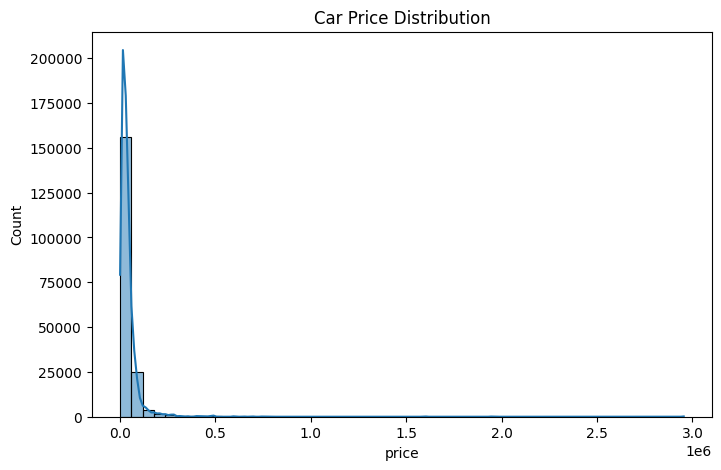

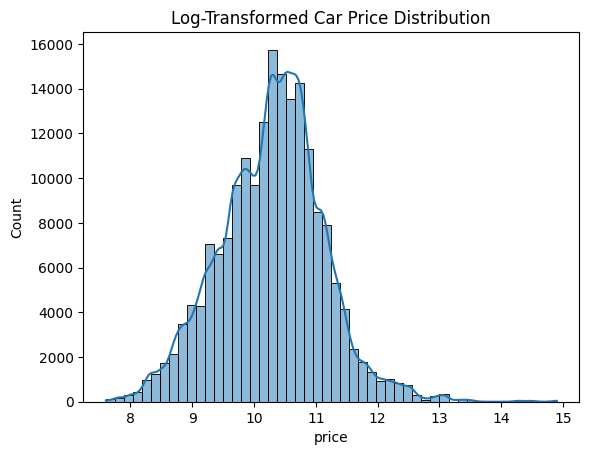

In [ ]:
# for target nvariable price distribution, lets check histogram and log-transformation of price

plt.figure(figsize=(8,5))
sns.histplot(data["price"], kde=True, bins=50)
plt.title("Car Price Distribution")
plt.show()

# Log transform check
sns.histplot(np.log1p(train_df["price"]), kde=True, bins=50)
plt.title("Log-Transformed Car Price Distribution")
plt.show()

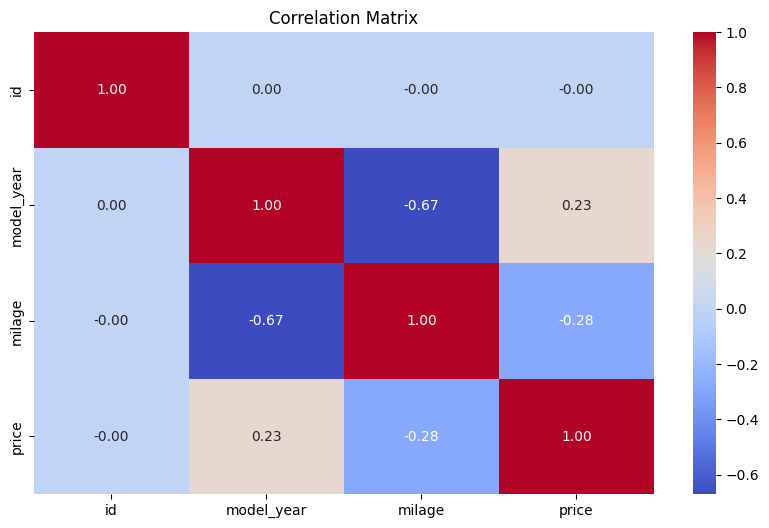

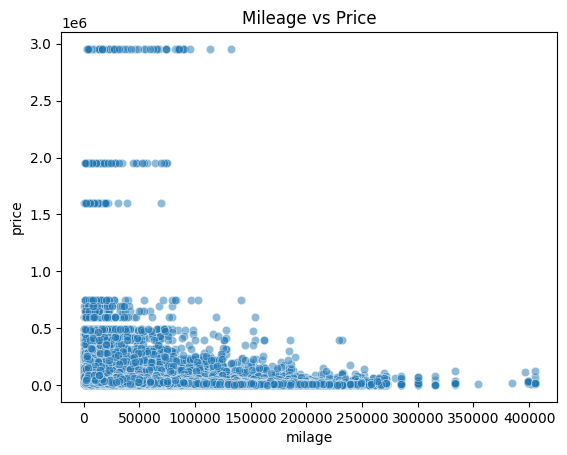

In [ ]:
#numerical features correlation heatmap

# Correlation matrix
corr = train_df.corr(numeric_only=True)
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# milage vs price
sns.scatterplot(x="milage", y="price", data=train_df, alpha=0.5)
plt.title("Mileage vs Price")
plt.show()


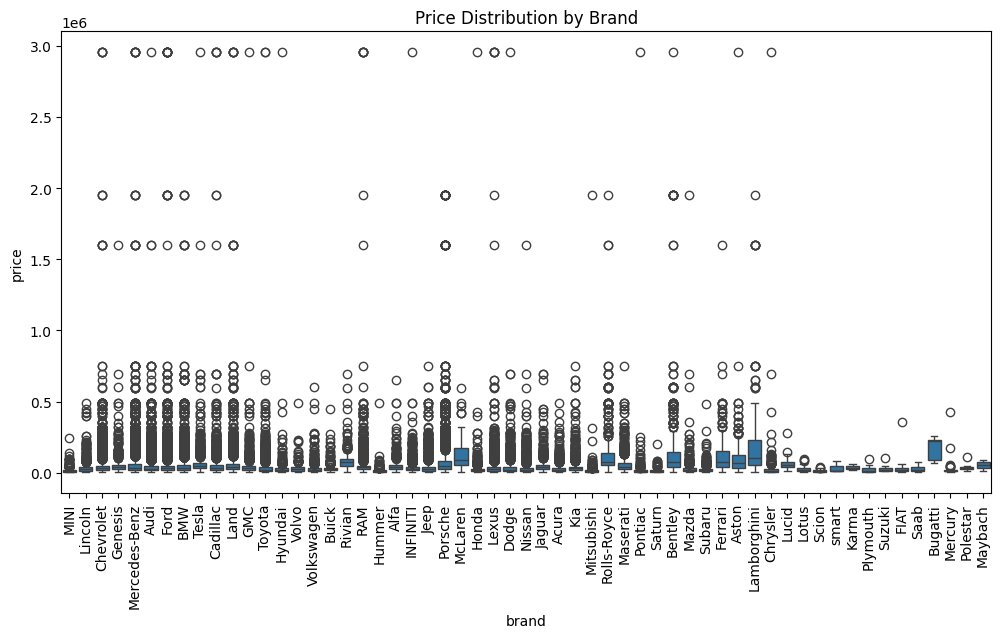

ValueError: Could not interpret value `trans_type` for `x`. An entry with this name does not appear in `data`.

In [ ]:
# Brand vs price
plt.figure(figsize=(12,6))
sns.boxplot(x="brand", y="price", data=train_df)
plt.xticks(rotation=90)
plt.title("Price Distribution by Brand")
plt.show()

# Transmission type vs price
sns.boxplot(x="trans_type", y="price", data=train_df)
plt.title("Price Distribution by Transmission Type")
plt.show()

# Fuel type vs price
sns.boxplot(x="fuel_type", y="price", data=train_df)
plt.title("Price Distribution by Fuel Type")
plt.show()


In [ ]:
# lets create two version of the dataset - one with original prices and another with capped prices to handle outliers
# keep original prices
train_df["price_raw"] = train_df["price"]

# cap extreme prices at 99th percentile
cap_value = np.percentile(train_df["price"], 99)
train_df["price_capped"] = np.where(train_df["price"] > cap_value, cap_value, train_df["price"])

print(f"99th percentile price cap: {cap_value}")


99th percentile price cap: 259500.0


In [ ]:
#Numerical Correlation Check for Categorical Features
def cat_mutual_info(df, target, cat_cols):
    mi_scores = {}
    for col in cat_cols:
        le = LabelEncoder()
        encoded = le.fit_transform(df[col].astype(str))
        mi = mutual_info_regression(encoded.reshape(-1,1), df[target])[0]
        mi_scores[col] = mi
    return sorted(mi_scores.items(), key=lambda x: x[1], reverse=True)

cat_cols = ["brand","model", "trans_type", "fuel_type", "accident", "engine", "ext_color_clean", "int_color_clean", "transmission"]
mi_scores = cat_mutual_info(train_df, "price_capped", cat_cols)

print("Mutual Information Scores (higher = stronger relation):")
for col, score in mi_scores:
    print(f"{col}: {score:.4f}")

Mutual Information Scores (higher = stronger relation):
engine: 0.5991
transmission: 0.4429
model: 0.4086
brand: 0.1417
int_color_clean: 0.0696
accident: 0.0584
ext_color_clean: 0.0455
trans_type: 0.0398
fuel_type: 0.0225


In [ ]:
#drop low importance categorical features based on mutual information scores

In [ ]:
train_df['brand'].unique()

array(['MINI', 'Lincoln', 'Chevrolet', 'Genesis', 'Mercedes-Benz', 'Audi',
       'Ford', 'BMW', 'Cadillac', 'Land', 'GMC', 'Toyota', 'Hyundai',
       'Volvo', 'Volkswagen', 'Buick', 'Rivian', 'RAM', 'Hummer', 'Alfa',
       'INFINITI', 'Jeep', 'Porsche', 'McLaren', 'Honda', 'Lexus',
       'Dodge', 'Nissan', 'Jaguar', 'Acura', 'Kia', 'Mitsubishi',
       'Rolls-Royce', 'Maserati', 'Pontiac', 'Saturn', 'Bentley', 'Tesla',
       'Mazda', 'Subaru', 'Ferrari', 'Aston', 'Lamborghini', 'Chrysler',
       'Lucid', 'Lotus', 'Scion', 'Plymouth', 'Suzuki', 'FIAT', 'Saab',
       'Bugatti', 'Mercury', 'Karma', 'Maybach', 'smart', 'Polestar'],
      dtype=object)

In [ ]:
brand_tiers = {
    "economy": [
        "Toyota", "Honda", "Hyundai", "Kia", "Nissan", "Chevrolet", "Ford",
        "Mazda", "Mitsubishi", "Volkswagen", "Subaru", "Buick", "Chrysler",
        "Dodge", "Jeep", "RAM", "GMC", "FIAT", "Mini", "Scion", "Pontiac",
        "Saturn", "Suzuki", "Plymouth", "Mercury", "smart", "Polestar"
    ],
    "premium": [
        "Audi", "BMW", "Mercedes-Benz", "Volvo", "Acura", "Lexus", "Infiniti",
        "Lincoln", "Cadillac", "Genesis", "Alfa", "Saab"
    ],
    "luxury": [
        "Porsche", "Jaguar", "Land", "Maserati", "Tesla", "Lucid", "Lotus",
        "Bentley", "Rolls-Royce", "Aston", "Ferrari", "Lamborghini", "McLaren",
        "Maybach", "Karma", "Rivian", "Hummer"
    ],
    "exotic": [
        "Bugatti"
    ]
}

def map_brand_to_tier(brand):
    for tier, brands in brand_tiers.items():
        if brand in brands:
            return tier
    return "other"  # fallback if a new brand appears later

train_df["brand_tier"] = train_df["brand"].apply(map_brand_to_tier)
# train_df.drop(columns=["int_color", "ext_color", "int_color_clean", "ext_color_clean"], inplace=True)

### Model Training
Baseline